In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import loggamma

In [3]:
df = pd.read_csv('SLS22.csv')

# 1 Uppvärmning. 
Följande uppgifter bör göra dig bekant med datamängden och förbereda data för användning när du bygger dina prediktiva modeller.

(a) Alla betyg i dataramen är för närvarande tal mellan 0 och 10. Normalisera dessa värden i dataramen så att de är mellan 0 och 1.

In [4]:
for col in df.columns:
    if df[col].dtype == np.float64:
        df[col] = df[col].apply(lambda x: x/10)

(b) Gör ett histogram för alla trickbetyg för trick 1−4. Vad observerar du? Finns det ett visst värde som dyker upp oftare än de andra? Om så är fallet, hur står detta värde i jämförelse med de andra?

<Axes: ylabel='Frequency'>

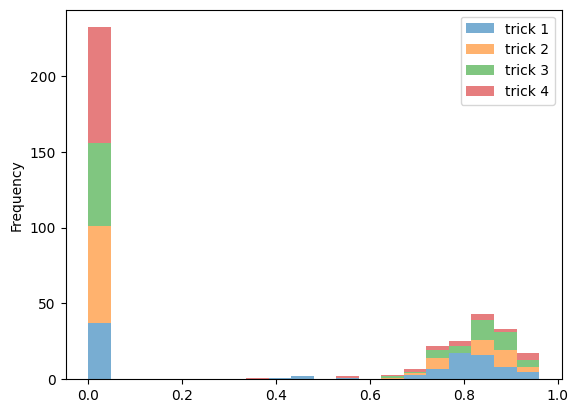

In [5]:
df[['trick 1', 'trick 2', 'trick 3', 'trick 4']].plot.hist(bins=20, stacked=True, alpha=0.6)

Svar: Det är tydligt att det absolut vanligaste talet är 0, dvs. att åkaren ej klarar trickcet.

(c) For varje trick 1−4 skapa en ny kolumn med namnet ’make i’ för i = 1, 2, 3, 4 så att värdet av ’make i’ i en given rad är 1 om skateboardåkaren landade trick i och 0 annars.

In [6]:
for i in range(1, 5):
    df[f"make {i}"] = df[f"trick {i}"].apply(lambda x: 1 if x > 0 else 0)

(d) För varje skateboardåkare skatta sannolikheten att ett trick får ett betyg som är större än 0.6 givet att skateboardåkaren landar tricket. Vad är sanno- likheten att skateboardåkaren inte lyckas landa ett visst trick? Vad observerar du? Relatera dina observationer till era observationer i del (b).

In [7]:
def compute_greater_than_point_six(group):
    # join tricks into one column if they are made
    trick_cols = [f'trick {i}' for i in range(1, 5)]
    make_cols = [f'make {i}' for i in range(1, 5)]
    tricks = group[trick_cols].stack()
    
    greater_than_point_six = len(tricks[tricks > 0.6])
    
    successfull_tricks = group[make_cols].sum().sum()

    return pd.Series([round(greater_than_point_six/successfull_tricks, 2), (len(tricks)-successfull_tricks)/len(tricks)], index=['greater than 0.6', 'portion failed'])

greater_than_point_six = df.groupby('id').apply(compute_greater_than_point_six)
print(greater_than_point_six)

           greater than 0.6  portion failed
id                                         
Berger                 1.00        0.833333
Decenzo                1.00        0.562500
Eaton                  1.00        0.375000
Foy                    1.00        0.500000
Fynn                   1.00        0.500000
Gustavo                1.00        0.600000
Hoban                  1.00        0.600000
Hoefler                1.00        0.562500
Horigome               1.00        0.437500
Huston                 1.00        0.625000
Jordan                 1.00        0.600000
Joslin                 1.00        0.550000
Majerus                0.33        0.625000
McClung                0.00        0.750000
Midler                 1.00        0.666667
Milou                  1.00        0.550000
Mota                   1.00        0.750000
Oliveira               1.00        0.583333
O’neill                1.00        0.750000
Papa                   1.00        0.562500
Pudwill                0.33     

Svar: Om en skateboardare klarar tricket så får de nästan alltid ett betyg över 0.6. Detta ser man också i histogrammen.

(e) Gör ett spridningsdiagram för runbetyg 1 mot runbetyg 2. Ser du någon tydligt korrelation från diagrammet?

0.19053845069841102


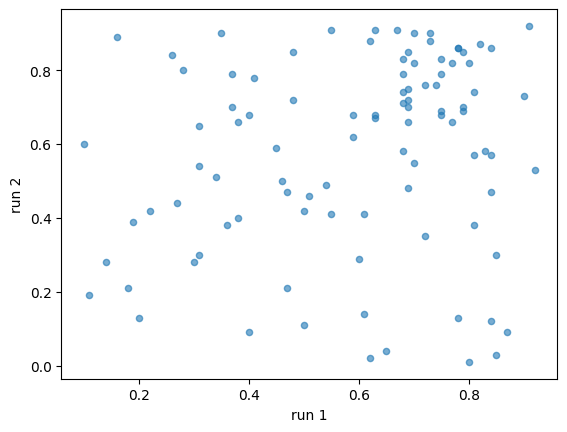

In [8]:
df.plot.scatter(x='run 1', y='run 2', alpha=0.6)
z = np.polyfit(df['run 1'], df['run 2'], 1)
p = np.poly1d(z)
ro = np.corrcoef(df['run 1'], df['run 2'])[0, 1]
print(ro)
plt.show()

Svar: Väldigt svag positiv korrerlation, ro=0.19. Många värden verkar vara koncentrerade i övre högra hörnet, men annars är spridningen väldigt stor.

# 2. En frekventistisk modell.

(a) Ge en punktskattning för varje θi, sannolikheten att skateboardåkaren i landar ett trick.
θi = x_bar, dvs. theta från ovan

(b) Ge en punktskattning för parametrarna [αi,βi]T för varje skateboardåkare i. Finns det skateboardåkare för vilka din valda punktskattning inte existera? I så fall föreslå en alternativ punktskattning för dessa αi, βi. Motivera dina val punktskattningar.

In [9]:
def estimate_alpha_beta(scores):
    mean = scores.mean()
    var = scores.var()
    if var == 0 or mean * (1 - mean) / var - 1 == 0:
        return mean * 10, (1 - mean) * 10
    alpha = mean * (mean * (1 - mean) / var - 1)
    beta = (1 - mean) * (mean * (1 - mean) / var - 1)
    return alpha, beta

In [10]:
interesting_cols = ['Majerus', 'Oliveira', 'Decenzo', 'Santiago', 
                    'Papa', 'Jordan', 'Ribeiro C', 
                    'Eaton', 'Hoefler', 'O’neill',
                    'Mota', 'Shirai', 'Hoban', 'Gustavo',
                    'Foy', 'Midler']
                    
gdf = df[df["id"].isin(interesting_cols)].groupby('id')

In [11]:
def compute_stats(group):
    total_tricks = 4 * len(group)
    passed_tricks = sum(group[f'make {i}'].sum() for i in range(1, 5))
    
    trick_scores = np.concatenate([group.loc[group[f'make {i}'] == 1, f'trick {i}'] for i in range(1, 5)])
    run_scores = np.concatenate([group[f'run {i}'] for i in range(1, 3)])
    
    theta = passed_tricks / total_tricks
    alpha_trick, beta_trick = estimate_alpha_beta(trick_scores)
    alpha_run, beta_run = estimate_alpha_beta(run_scores)
    
    return pd.Series(
        [theta, alpha_trick, beta_trick, alpha_run, beta_run], 
        index=['theta', 'alpha_trick', 'beta_trick', 'alpha_run', 'beta_run']
    )

freq_params = gdf.apply(compute_stats)
print(freq_params)

              theta  alpha_trick  beta_trick   alpha_run   beta_run
id                                                                 
Decenzo    0.437500    24.455929    5.110825    4.164506   2.834664
Eaton      0.625000    75.408256   20.045233  103.573288  36.865068
Foy        0.500000    51.589516    9.104032    3.506609   4.088934
Gustavo    0.400000    70.644593   17.523386    1.228081   0.856946
Hoban      0.400000   107.698921   15.034892    3.632207   2.096826
Hoefler    0.437500    32.522583    9.403399    1.754494   0.965652
Jordan     0.400000    23.062983    3.638010    3.608210   1.228533
Majerus    0.375000     2.912773    2.724852    1.755202   2.474200
Midler     0.333333    43.723171   10.423171    1.290513   0.819317
Mota       0.250000    24.006667    6.771111    4.056173   4.573982
Oliveira   0.416667    68.878648   17.870279    5.389884   4.038485
O’neill    0.250000  1252.666250  232.708750    0.599388   0.732585
Papa       0.437500    22.314765    6.346401    

(d) Använd din modell för [Xi,Yi]T för att simulera 5000 LCQ:ar och för varje simulering extrahera de fyra skateboardåkare W = [W1,W2,W3,W4]^T med de högsta totalbetygen. Vad är typvärdet för W1, ... , W5000? De riktiga vinnarna för LCQ:en är Gustavo, Hoban, Eaton, Decenzo. Hur många av de riktiga vinnarna förutsägs av typvärdet? Vad är skattade sannolikheten för de riktiga vinnarna baserat på dina simuleringar? Av typvärdet?

In [12]:
def simulate_LCQ(theta, alpha_trick, beta_trick, alpha_run, beta_run):
    best_run = max(np.random.beta(alpha_run, beta_run, 2))
    
    trick_scores = [np.random.beta(alpha_trick, beta_trick) for _ in range(4) if np.random.uniform() < theta]
    two_best_tricks = sorted(trick_scores, reverse=True)[:2]
    
    return best_run + sum(two_best_tricks)

In [13]:
def simulate_n_LCQs(n, theta, alpha_trick, beta_trick, alpha_run, beta_run):
    result = np.zeros(n)
    for i in range(n):
        theta_i = theta if np.isscalar(theta) else theta[i]
        alpha_trick_i = alpha_trick if np.isscalar(alpha_trick) else alpha_trick[i]
        beta_trick_i = beta_trick if np.isscalar(beta_trick) else beta_trick[i]
        alpha_run_i = alpha_run if np.isscalar(alpha_run) else alpha_run[i]
        beta_run_i = beta_run if np.isscalar(beta_run) else beta_run[i]
        
        result[i] = simulate_LCQ(theta_i, alpha_trick_i, beta_trick_i, alpha_run_i, beta_run_i)
    return result

In [14]:
def LCQ_results(scores_df):
    top4_per_row = scores_df.apply(lambda row: tuple(sorted(row.nlargest(4).index.tolist())), axis=1)
    # most common top 4
    top4_groups = top4_per_row.value_counts() / len(scores_df)
    print('Vanligaste top 4:')
    print(top4_groups.head(1))
    
    top4_individually = pd.Series([item for sublist in top4_per_row for item in sublist]).value_counts() / len(top4_per_row)
    print('\nVanligaste top 4 individerna:')
    print(top4_individually.head(4))
    
    winners = ('Decenzo', 'Eaton', 'Gustavo', 'Hoban')
    print('\nSannolikheten att de fyra vinnarna vann tillsammans:')
    print(top4_groups.loc[[winners]])
    
    print('\nSannolikheten att de fyra vinnarna vann individuellt:')
    for winner in winners:
        print(winner, top4_individually.loc[winner])
    

In [15]:
columns = {}
for _, row in freq_params.iterrows():
    columns[row.name] = simulate_n_LCQs(5000, row['theta'], row['alpha_trick'], row['beta_trick'], row['alpha_run'], row['beta_run'])
frequentist_scores_df = pd.DataFrame(columns)

In [16]:
LCQ_results(frequentist_scores_df)

Vanligaste top 4:
(Hoban, Hoefler, Jordan, Shirai)    0.0112
Name: count, dtype: float64

Vanligaste top 4 individerna:
Eaton     0.4914
Jordan    0.4760
Shirai    0.4524
Hoban     0.4336
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann tillsammans:
(Decenzo, Eaton, Gustavo, Hoban)    0.0056
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann individuellt:
Decenzo 0.3408
Eaton 0.4914
Gustavo 0.3118
Hoban 0.4336


# 3. En bayesiansk modell.

(a) Föreslå en simultan apriorifördelning för parametrarna [Θi , Ai , Bi ]T för Xi där vi antar Θi ⊥ Ai, Bi för alla i. Motivera ditt val.

$\Theta_{i} \perp\!\!\!\perp A_{i}, B_{i} \implies f_{\Theta_{i}, A_{i}, B_{i}}(\theta_{i}, \beta_{i}, \alpha_{i})=f_{\Theta_{i}}(\theta_{i}) f_{A_{i}, B_{i}}(\alpha_{i}, \beta_{i})$ och vi kan därmed behandla $\Theta_{i}$ och $A_{i}, B_{i}$ separat.

$Ber(\theta_{i})$ har som konjugerad apriorifördelning $Beta(a_{i}, b_{i})$, och vi kommer därmed använda den.

$Beta(\alpha_{i}, \beta_{i})$ har ingen konjugerad apriorifördelning, men med hjälp av samma knep som i Exempel 10.8 så kan vi få följande apriorifördelning:
$$
f_{A_{i}, B_{i}}(\alpha_{i}, \beta_{i}) = \frac{\lambda^{\phi_{i}}}{\Gamma(\phi_{i})} (\alpha_{i} + \beta_{i} + 1)^{\phi_{i} - 1} e^{-\lambda_{i}(\alpha_{i} + \beta_{i} + 1)} (\alpha_{i} + \beta_{i})^{-1}
$$
Sammansatt får vi följande funktion för den simultana apriorifördelningen:
$$
f_{\Theta_{i}, A_{i}, B_{i}}(\theta_{i}, \alpha_{i}, \beta_{i}) = (\frac{\Gamma(a_{i} + b_{i})}{\Gamma(a_{i}) \Gamma(b_{i})} \theta_{i}^{a_{i}-1} (1-\theta_{i})^{b_{i}-1}) (\frac{\lambda^{\phi_{i}}}{\Gamma(\phi_{i})} (\alpha_{i} + \beta_{i} + 1)^{\phi_{i} - 1} e^{-\lambda_{i}(\alpha_{i} + \beta_{i} + 1)} (\alpha_{i} + \beta_{i})^{-1})
$$
Vi kommer använda $a_{i}=b_{i}=1$, som val för en icke-informativ fördelning för $\Theta_{i}$. Vi väljer samma värden som i Exempel 10.8 för $A_{i}, B_{i}$, dvs $\lambda_{i}=1, \phi_{i}=3$.

(b) Generera 5000 slumpmässiga utfall från aposteriorifördelningen fθi,αi,βi|Xi (θi, αi, βi|xi).
Plotta dina resulterande utfall för de marginella aposteriorifördelningarna:
fθi|Xi (θi|xi) and fαi,βi|Xi (αi, βi|xi).
Beräkna det aposteriori stickprovsmedelvärdet och den aposteriori stickprov-
sorvariansen för varje parameter θi,αi, och βi för alla skateboardåkare.

Vi utnyttjar det faktum att $f_{\Theta | \mathbf{X}}(\theta | \mathbf{x}) \propto f_{\mathbf{X} | \Theta}(\mathbf{x} | \theta) f_{\Theta}(\theta)$ tillsammans med metropolisalgoritmen som har den trevliga egenskapen att $f$ ej måste vara normaliserad. 

In [17]:
lamda = 0.5
phi = 5

def log_prior_trick(theta, alpha, beta, a = 1, b = 1):
    return (a - 1) * np.log(theta) + (b - 1) * np.log(1 - theta) + (phi - 1) * np.log(alpha + beta + 1) - lamda*(alpha + beta + 1) - np.log(alpha + beta)

def log_posterior_trick(data, theta, alpha, beta, a = 1, b = 1): # ignoring constants
    log_p = log_prior_trick(theta, alpha, beta, a, b)
    
    for x in data:
        if x == 0:
            log_p += np.log(1 - theta)
        else:
            log_p += np.log(theta) + loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha - 1) * np.log(x) + (beta - 1) * np.log(1 - x)

    return log_p
        

In [18]:
def metropolis_algorithm(data, log_posterior_func, n_samples, proposal_sd, start_params):
    # Initialize the chain with the starting parameters
    current_params = start_params
    current_log_posterior = log_posterior_func(data, *current_params)

    samples = np.empty((n_samples, len(start_params)))
    for i in range(n_samples):
        proposed_params = [np.exp(np.log(param) + proposal_sd[i] * np.random.normal(0, 1, 1)[0]) for i, param in enumerate(current_params)]
        if len(start_params) == 3:
            proposed_params[0] = np.clip(proposed_params[0], 1e-6, 1-1e-6)
        
        proposed_log_posterior = log_posterior_func(data, *proposed_params)
        
        acceptance_prob = min(1, np.exp(proposed_log_posterior - current_log_posterior))

        # Accept or reject the proposal
        if np.random.uniform() < acceptance_prob:
            current_params = proposed_params
            current_log_posterior = proposed_log_posterior

        samples[i] = current_params
    return samples

In [19]:
n_chains = 4
n_samples = 6000
proposal_sd = [0.3, 0.3, 0.3]

trick_samples_dict = {}
for name, group in gdf:
    theta_start = np.linspace(0.05, 0.95, n_chains)
    c_start = freq_params.loc[name, 'alpha_trick'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    d_start = freq_params.loc[name, 'beta_trick'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    
    tricks = np.concatenate([group[f'trick {i}'] for i in range(1, 5)])
    
    samples_list = []
    for i in range(n_chains):
        samples = metropolis_algorithm(tricks, log_posterior_trick, n_samples, proposal_sd, [theta_start[i], c_start[i], d_start[i]])
        samples_list.append(samples)
    trick_samples_dict[name] = samples_list

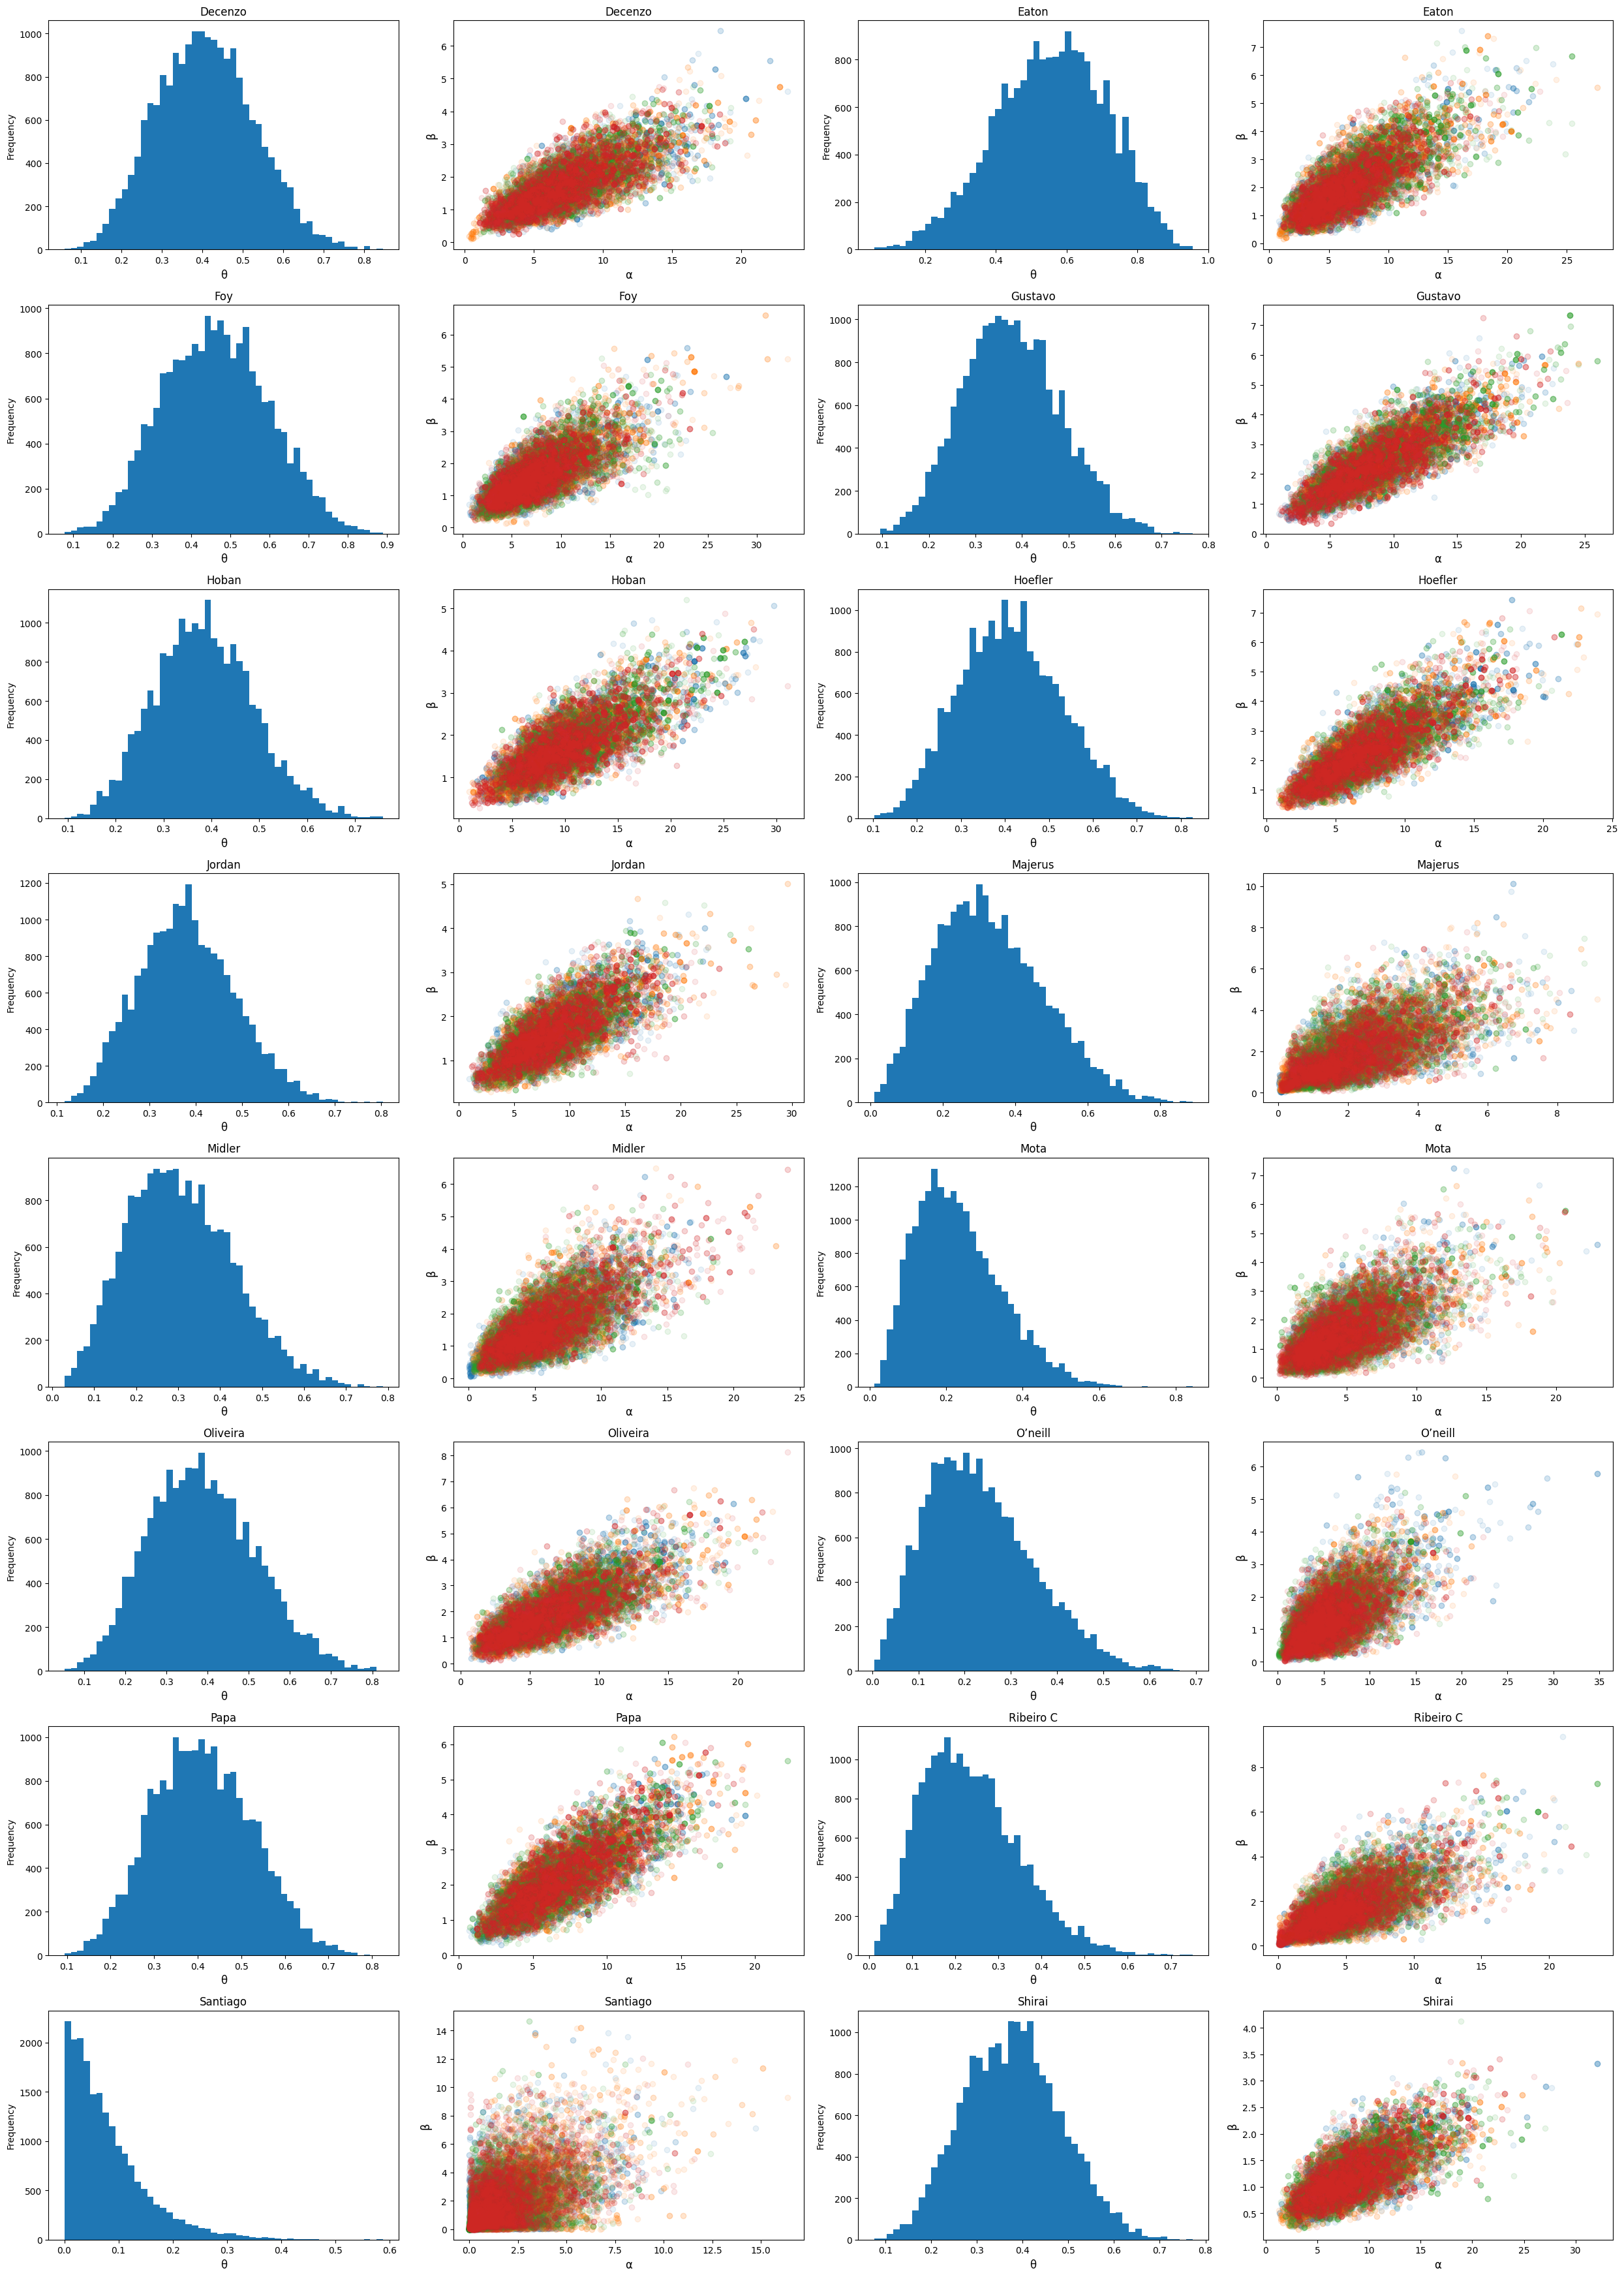

In [20]:
rows = len(trick_samples_dict) // 2
fig, axs = plt.subplots(rows, 4, figsize=(25, 25*1.4))

# hist of theta, heatmap of alpha and beta
# ignore first 1000 samples
for i, (name, samples) in enumerate(trick_samples_dict.items()):
    row = i // 2
    col = 2 * (i % 2)
    
    thetas = np.concatenate([sample[1000:, 0] for sample in samples], axis=0)
    alpha_tricks, beta_tricks = [[sample[1000:, i] for sample in samples] for i in range(1, 3)]
    
    axs[row, col].hist(thetas, bins=50)
    axs[row, col].set_title(f"{name}")
    axs[row, col].set_xlabel('θ', fontsize='large')
    axs[row, col].set_ylabel('Frequency')
    
    for j in range(n_chains):
        axs[row, col+1].plot(alpha_tricks[j], beta_tricks[j], 'o', alpha=0.1)
        axs[row, col+1].set_title(f"{name}")
        axs[row, col+1].set_xlabel('α', fontsize='large')
        axs[row, col+1].set_ylabel('β', fontsize='large')
    
plt.tight_layout()

(c) Föreslå en (simultan) apriorifördelning för parametrarna för din modell Yi från uppgift 2(c) och motivera ditt val. Du får anta att modellens parame- trar för skateboardåkaren i är oberoende av alla andra parametrar inklusive θi,αi och βi. Generera 5000 utfall från aposteriorifördelningen (se till att spara dessa utfall!) och gör ett spridningsdiagram av resultatet. Vad är stick- provsmedelvärdet och stickprovsvariansen för var och en av dina parametrar baserat på dina utfall?

In [21]:
def log_prior_run(alpha, beta):
    return (phi - 1) * np.log(alpha + beta + 1) - lamda*(alpha + beta + 1) - np.log(alpha + beta)

def log_posterior_run(data, alpha, beta): # ignoring constants
    log_p = log_prior_run(alpha, beta)
    
    for x in data:
        log_p += loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) + (alpha - 1) * np.log(x) + (beta - 1) * np.log(1 - x)

    return log_p
        

In [22]:
n_chains = 4
n_samples = 6000
proposal_sd = [0.5, 0.5]

run_samples_dict = {}
for name, group in gdf:
    c_start = freq_params.loc[name, 'alpha_run'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    d_start = freq_params.loc[name, 'beta_run'] + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    
    runs = np.concatenate([group[f'run {i}'] for i in range(1, 3)])
    
    samples_list = []
    for i in range(n_chains):
        samples = metropolis_algorithm(runs, log_posterior_run, n_samples, proposal_sd, [c_start[i], d_start[i]])
        samples_list.append(samples)
    run_samples_dict[name] = samples_list

IndexError: index 2 is out of bounds for axis 0 with size 2

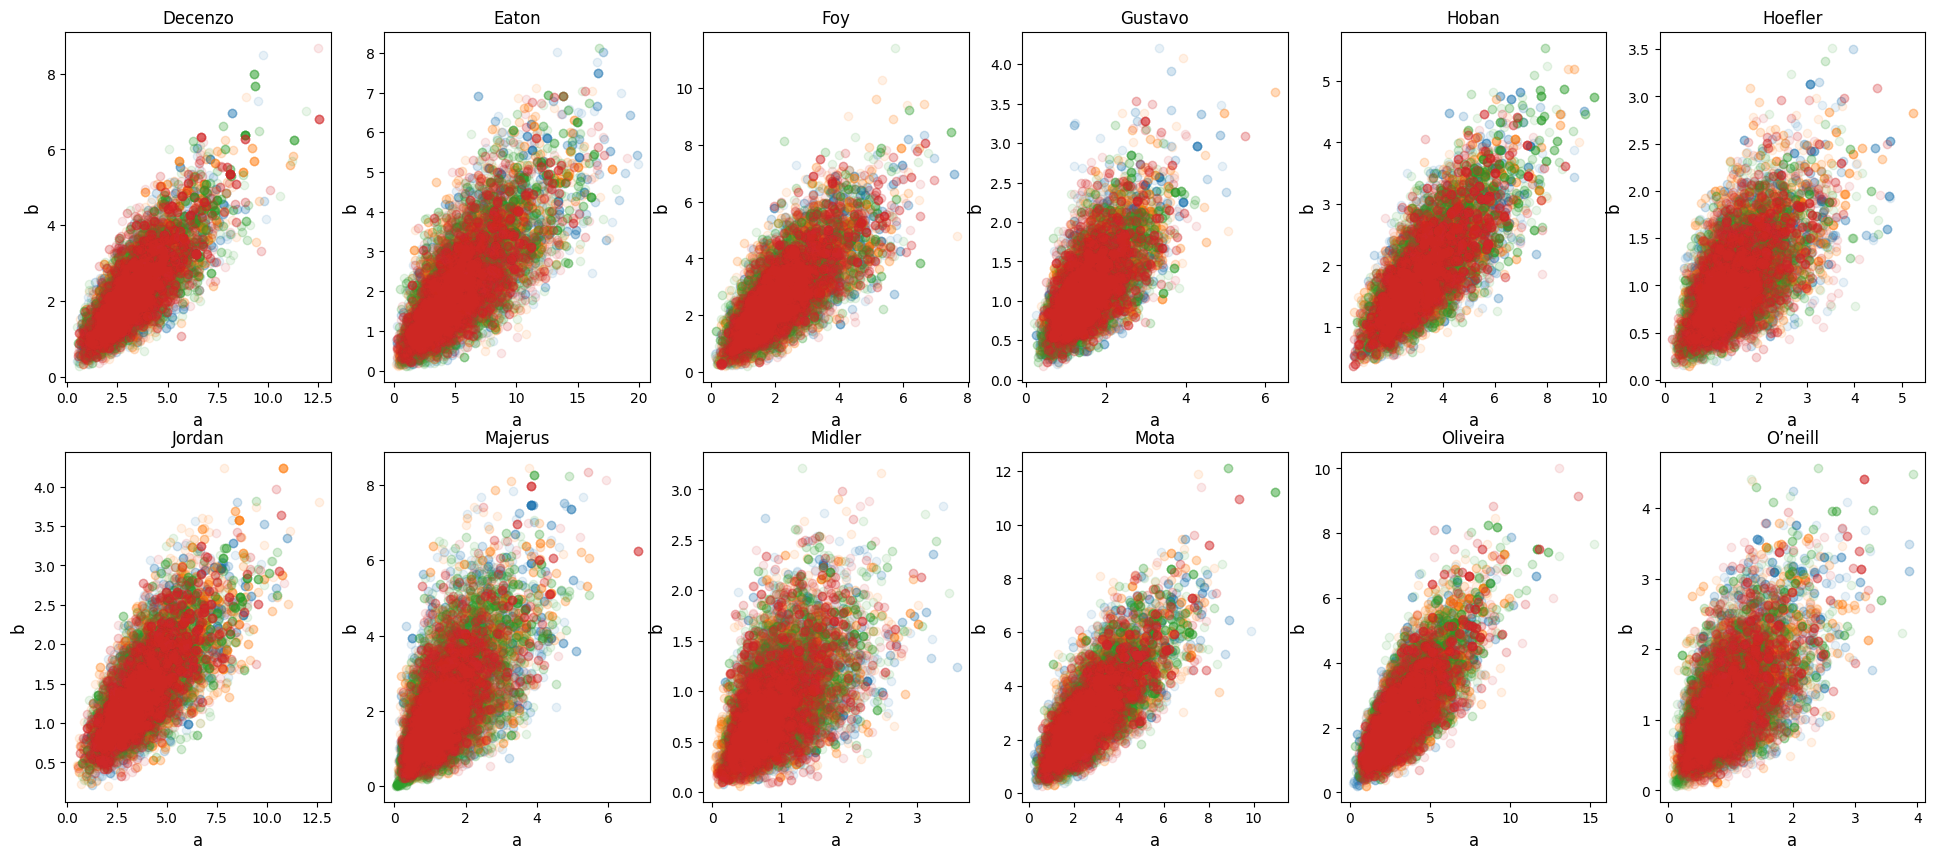

In [24]:
per_row = 6
rows = len(run_samples_dict) // per_row
fig, axs = plt.subplots(rows, per_row, figsize=(24, 10))

# hist of theta, heatmap of alpha and beta
# ignore first 1000 samples
for i, (name, samples) in enumerate(run_samples_dict.items()):
    row = i // per_row
    col = i % per_row
    alpha_tricks, beta_tricks = [[sample[1000:, i] for sample in samples] for i in range(2)]

    for j in range(n_chains):
        axs[row, col].plot(alpha_tricks[j], beta_tricks[j], 'o', alpha=0.1)
        axs[row, col].set_title(f"{name}")
        axs[row, col].set_xlabel('a', fontsize='large')
        axs[row, col].set_ylabel('b', fontsize='large')
    
plt.tight_layout()

In [25]:
bayes_samples = {}
for name, trick_samples in trick_samples_dict.items():
    run_samples = run_samples_dict[name]
    bayes_samples[name] = [np.concatenate([trick_samples[i][1000:], run_samples[i][1000:]], axis=1) for i in range(n_chains)]

In [26]:
# make df of sample mean and variance for each parameter for each skater. only want to look at samples after burn-in
bayesian_params = pd.DataFrame(
    columns=['theta_mean', 'theta_var', 'alpha_trick_mean', 'alpha_trick_var', 'beta_trick_mean', 'beta_trick_var', 'alpha_run_mean', 'alpha_run_var', 'beta_run_mean', 'beta_run_var']
)
for name, samples in bayes_samples.items():
    thetas, alpha_tricks, beta_tricks, alpha_runs, beta_runs = [np.concatenate([sample[:, i] for sample in samples], axis=0) for i in range(5)]
    bayesian_params.loc[name] = [thetas.mean(), thetas.var(), alpha_tricks.mean(), alpha_tricks.var(), beta_tricks.mean(), beta_tricks.var(), alpha_runs.mean(), alpha_runs.var(), beta_runs.mean(), beta_runs.var()]
print(bayesian_params)

           theta_mean  theta_var  alpha_trick_mean  alpha_trick_var  \
Decenzo      0.408824   0.014489          7.409432        10.672808   
Eaton        0.556474   0.024548          7.026624        11.681229   
Foy          0.463780   0.017873          7.914233        13.593033   
Gustavo      0.378024   0.011007          8.996520        13.495471   
Hoban        0.385193   0.010588         10.363898        18.284637   
Hoefler      0.413983   0.013589          7.407407        10.999657   
Jordan       0.380697   0.010606          8.673131        12.743039   
Majerus      0.329193   0.022120          2.223242         1.931780   
Midler       0.305980   0.015497          5.868700        10.163085   
Mota         0.232069   0.012496          5.029370         8.419745   
Oliveira     0.388562   0.016446          6.907634        11.186762   
O’neill      0.233299   0.013244          5.984762        12.052319   
Papa         0.410968   0.013050          7.022091         9.644426   
Ribeir

(d) Använd din bayesiansk modell för [Xi,Yi]T för att simulera 5000 LCQ:ar genom att ta utfall från de lämpliga de aposteriori prediktiva fördelningarna. Vad är typvärdet av dina utfall W1,...,W5000? Hur många av de riktiga vinnarna förutsägs? Vad är den skattade sannolikheten för de riktiga vinnarna baserat på dina utfall? Av typvärdet?

In [27]:
columns = {}
for name, samples in bayes_samples.items():
    idxs = [np.random.choice(range(0, 5000), size=1250, replace=False) for _ in range(4)]
    thetas, alpha_tricks, beta_tricks, alpha_runs, beta_runs = np.concatenate([sample[idxs[i], :] for i, sample in enumerate(samples)], axis=0).T
    columns[name] = simulate_n_LCQs(5000, thetas, alpha_tricks, beta_tricks, alpha_runs, beta_runs)
bayes_scores_df = pd.DataFrame(columns)

In [28]:
LCQ_results(bayes_scores_df)

Vanligaste top 4:
(Eaton, Hoban, Jordan, Shirai)    0.009
Name: count, dtype: float64

Vanligaste top 4 individerna:
Eaton     0.5264
Jordan    0.4286
Hoban     0.3960
Shirai    0.3718
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann tillsammans:
(Decenzo, Eaton, Gustavo, Hoban)    0.0056
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann individuellt:
Decenzo 0.3388
Eaton 0.5264
Gustavo 0.2772
Hoban 0.396


# 4. En bayesiansk modell med en hierarki. 
##### För att ta hänsyn till möjliga variationer i skateboardåkarnas prestationer mellan olika tävlingar kan vi bygga en modell som använda en hierarki. Som vi såg i föreläsningarna kan vi bygga en bayesiansk hierarki för Vi ∼ Ber(θi) om vi grupperar utfall vi enligt de olika tävlingarna. För enkelhets skull använder vi våra frekventisktiska punktskattningar för parametrarna αi,βi och parametrarna för Yi från uppgift 2.

(a) Anta att Θi|Ci = ci, Di = ci ∼ Beta(ci, di) och välj en lämplig simultan apri- orifördelning för [Θi, Ci, Di]T . (Här är Ci och Di hyperparametrarna för den bayesianska hierarkiska modellen som i råttorna exemplet i föreläsning 11.) Motivera ditt val.

In [29]:
lamda = 0.5
phi = 10
def log_posterior_hierarchical(data, c, d, n = 4): # ignoring constants
    log_p = log_prior_run(c, d)

    for x in data:
        log_p += loggamma(c + d) - loggamma(c) - loggamma(d) + loggamma(c + x) + loggamma(d + n - x) - loggamma(c + d + n)
    return log_p
    

In [38]:
n_chains = 4
n_samples = 10000
proposal_sd = [0.1, 0.1]
make_cols = [f'make {i}' for i in range(1, 5)]

hierarchy_chains_dict = {}
for name, group in gdf:
    # for each row, calculate the fraction of tricks made
    tricks_made = group[make_cols].sum(axis=1).values 

    # if all trick_made are the same
    if len(set(tricks_made)) == 1:
        mom_c, mom_d = 1, 1
    else:
        mom = estimate_alpha_beta(tricks_made / 4)
        mom_c, mom_d = mom if mom != (0, 0) else (3, 3)
    
    c_start = mom_c + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))
    d_start = mom_d + np.exp(stats.cauchy.rvs(size=n_chains, scale=0.05))

    samples_list = []
    for i in range(n_chains):
        samples = metropolis_algorithm(tricks_made, log_posterior_hierarchical, n_samples, proposal_sd, [c_start[i], d_start[i]])
        samples_list.append(samples[n_samples-5000:])
    hierarchy_chains_dict[name] = samples_list

/var/folders/q5/6vbw5t_91_l67h7nh6f4cqph0000gn/T/ipykernel_798/1816217355.py:14: RuntimeWarning: overflow encountered in exp
  acceptance_prob = min(1, np.exp(proposed_log_posterior - current_log_posterior))


In [39]:
hierarchy_5000_samples_dict = {}
for name, cd_samples in hierarchy_chains_dict.items():
    # take 1250 cd_samples from each chain and concatenate them
    idxs = [np.random.choice(range(0, 5000), size=1250, replace=False) for _ in range(4)]
    cd_samples = np.concatenate([cd_samples[i][idxs[i], :] for i in range(4)], axis=0)
    
    theta_samples = np.array([stats.beta.rvs(c, d) for c, d in cd_samples])

    hierarchy_5000_samples_dict[name] = np.column_stack((theta_samples, cd_samples))

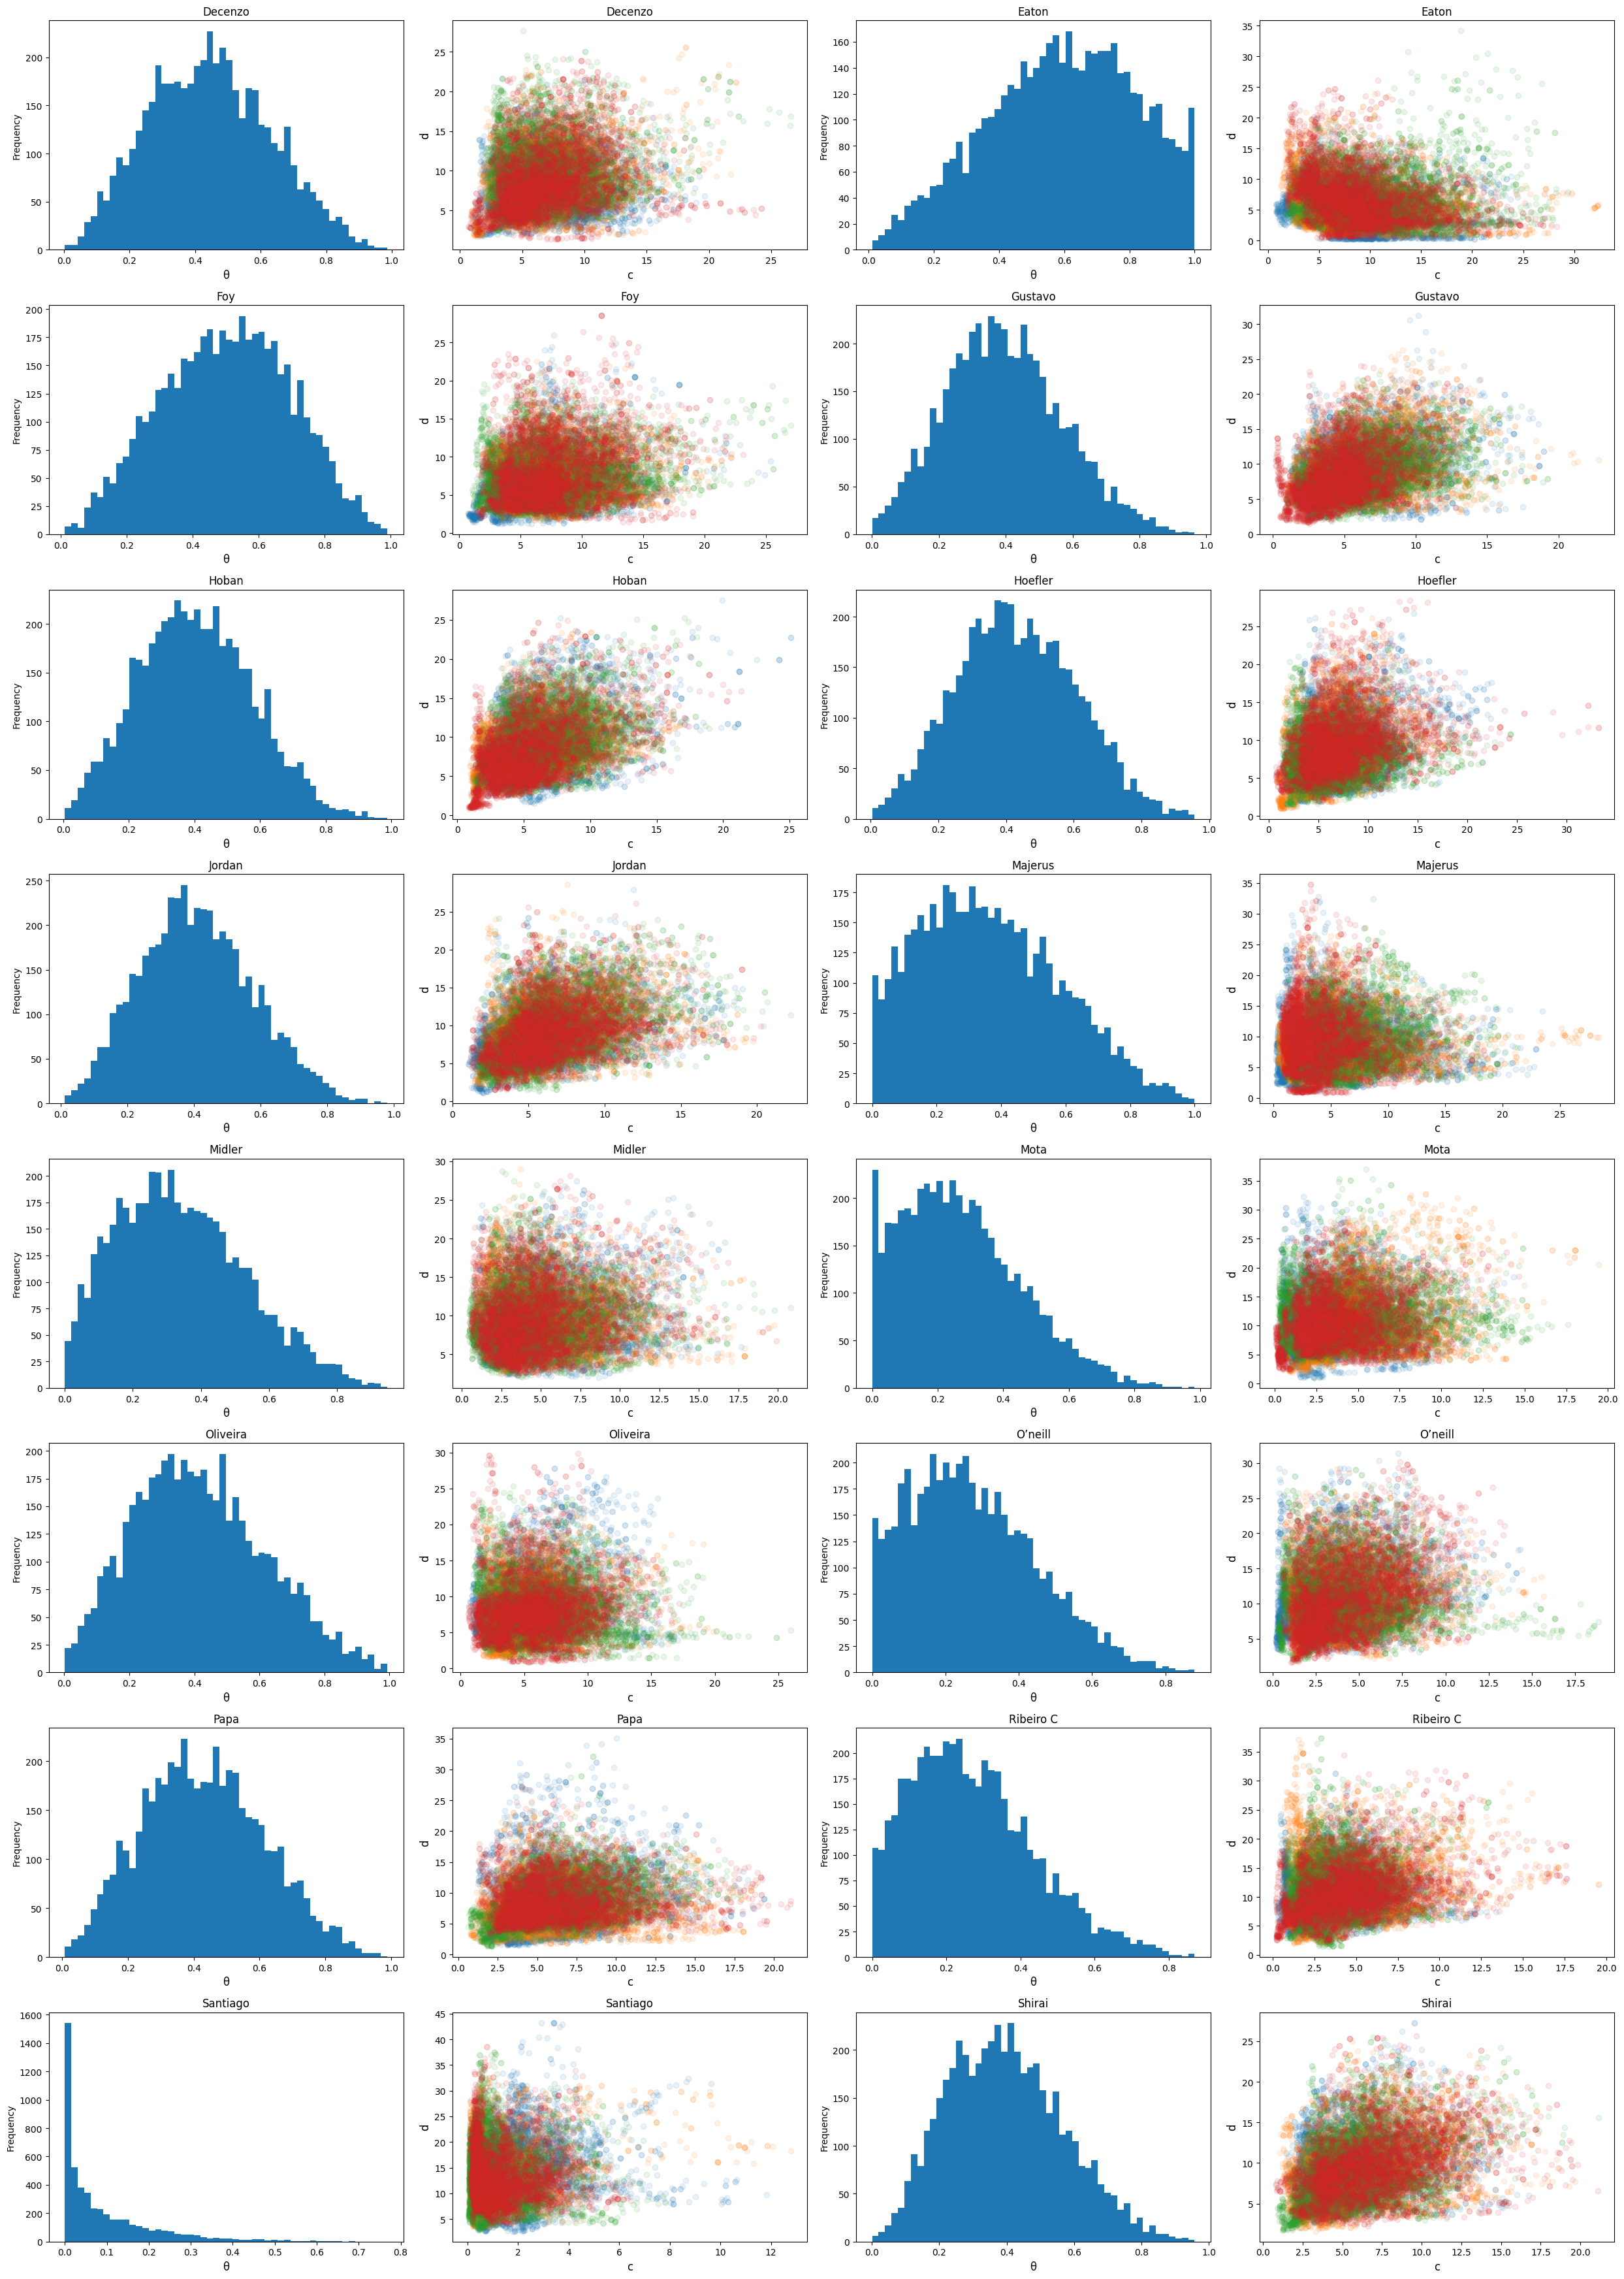

In [40]:
rows = len(trick_samples_dict) // 2
fig, axs = plt.subplots(rows, 4, figsize=(25, 25*1.4))

# hist of theta, heatmap of alpha and beta
# ignore first 1000 samples
for i, (name, samples) in enumerate(hierarchy_5000_samples_dict.items()):
    row = i // 2
    col = 2 * (i % 2)
    
    thetas = samples[:, 0]
    cs, ds = [[sample[:, i] for sample in hierarchy_chains_dict[name]] for i in range(0, 2)]
    
    axs[row, col].hist(thetas, bins=50)
    axs[row, col].set_title(f"{name}")
    axs[row, col].set_xlabel('θ', fontsize='large')
    axs[row, col].set_ylabel('Frequency')
    
    for j in range(n_chains):
        axs[row, col+1].plot(cs[j], ds[j], 'o', alpha=0.1)
        axs[row, col+1].set_title(f"{name}")
        axs[row, col+1].set_xlabel('c', fontsize='large')
        axs[row, col+1].set_ylabel('d', fontsize='large')
    
plt.tight_layout()

In [41]:
hierarchical_params = pd.DataFrame(
    columns=['theta_mean', 'theta_var', 'c_mean', 'c_var', 'd_mean', 'd_var']
)
for name, samples in hierarchy_5000_samples_dict.items():
    thetas, cs, ds = samples.T
    hierarchical_params.loc[name] = [thetas.mean(), thetas.var(), cs.mean(), cs.var(), ds.mean(), ds.var()]
print(hierarchical_params)


           theta_mean  theta_var    c_mean      c_var     d_mean      d_var
Decenzo      0.445448   0.033775  7.041628  10.407261   8.901102  14.672531
Eaton        0.590910   0.051230  9.396369  21.096587   6.394494  14.230833
Foy          0.502576   0.037486  7.512439  12.809076   7.451460  12.712776
Gustavo      0.396309   0.030216  6.050059   8.568938   9.105009  14.091333
Hoban        0.404192   0.029526  6.172955   9.006939   8.971400  13.865021
Hoefler      0.432275   0.031333  6.809283  11.943411   8.857999  15.210438
Jordan       0.409805   0.028110  6.545577   9.441631   9.338941  14.293608
Majerus      0.367960   0.046625  5.474679  13.546058   9.284706  21.096489
Midler       0.342158   0.035057  4.990090   7.893084   9.677070  17.894596
Mota         0.274861   0.032363  4.206302   7.154336  11.077528  24.551237
Oliveira     0.417916   0.040311  5.849394   8.844025   8.391602  16.413747
O’neill      0.277084   0.029678  4.095196   5.910617  10.952864  21.713235
Papa        

In [42]:
avg_bayes_theta_var = bayesian_params['theta_var'].mean()
avg_hier_theta_var = hierarchical_params['theta_var'].mean()
print(f"Average theta variance for Bayesian model: {avg_bayes_theta_var}")
print(f"Average theta variance for hierarchical model: {avg_hier_theta_var}")
print(f"Ratio of theta variance for Hierarchical model vs. Bayesian model: {avg_hier_theta_var / avg_bayes_theta_var}")

Average theta variance for Bayesian model: 0.014021902626601442
Average theta variance for hierarchical model: 0.03311636653313132
Ratio of theta variance for Hierarchical model vs. Bayesian model: 2.3617598420848465


In [43]:
col_dict = {}
for name, samples in hierarchy_5000_samples_dict.items():
    thetas = samples[:, 0]
    freq_row = freq_params.loc[name]
    # frequentist estimates for alpha and beta
    col_dict[name] = simulate_n_LCQs(5000, thetas, freq_row['alpha_trick'], freq_row['beta_trick'], freq_row['alpha_run'], freq_row['beta_run'])
    
hierarchical_scores_df = pd.DataFrame(col_dict)

In [44]:
LCQ_results(hierarchical_scores_df)

Vanligaste top 4:
(Eaton, Hoban, Jordan, Shirai)    0.0112
Name: count, dtype: float64

Vanligaste top 4 individerna:
Jordan    0.4934
Eaton     0.4310
Shirai    0.4310
Hoban     0.4266
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann tillsammans:
(Decenzo, Eaton, Gustavo, Hoban)    0.0026
Name: count, dtype: float64

Sannolikheten att de fyra vinnarna vann individuellt:
Decenzo 0.341
Eaton 0.431
Gustavo 0.303
Hoban 0.4266


In [45]:
expected_runs_and_tricks = pd.DataFrame(
    columns=['E[Z_freq]', 'E[Z_bayes]', 'E[Y_freq]', 'E[Y_bayes]', 'E[O_bayes]', 'E[O_hierarki]', 'Var[O_bayes]', 'Var[O_hierarki]']
)
for name, params in freq_params.iterrows():
    cols = ['alpha_trick_mean', 'beta_trick_mean', 'alpha_run_mean', 'beta_run_mean']
    alpha_trick_freq, beta_trick_freq, alpha_run_freq, beta_run_freq = params[1:]
    alpha_trick_bayes, beta_trick_bayes, alpha_run_bayes, beta_run_bayes = bayesian_params.loc[name][cols]

    e_trick_freq = alpha_trick_freq / (alpha_trick_freq + beta_trick_freq)
    e_run_freq = alpha_run_freq / (alpha_run_freq + beta_run_freq)

    e_trick_bayes = alpha_trick_bayes / (alpha_trick_bayes + beta_trick_bayes)
    e_run_bayes = alpha_run_bayes / (alpha_run_bayes + beta_run_bayes)
    
    LCQs_bayes = bayes_scores_df[name]
    LCQs_hier = hierarchical_scores_df[name]

    expected_runs_and_tricks.loc[name] = [e_trick_freq, e_trick_bayes, e_run_freq, e_run_bayes, LCQs_bayes.mean(), LCQs_hier.mean(), LCQs_bayes.var(), LCQs_hier.var()]
print(expected_runs_and_tricks)

           E[Z_freq]  E[Z_bayes]  E[Y_freq]  E[Y_bayes]  E[O_bayes]  \
Decenzo     0.827143    0.807201   0.595000    0.595460    1.835127   
Eaton       0.790000    0.765871   0.737500    0.715206    2.120807   
Foy         0.850000    0.824033   0.461667    0.447245    1.824171   
Gustavo     0.801250    0.783542   0.589000    0.574798    1.748130   
Hoban       0.877500    0.854092   0.634000    0.635391    1.893547   
Hoefler     0.775714    0.758117   0.645000    0.587424    1.801849   
Jordan      0.863750    0.841763   0.746000    0.730042    1.956740   
Majerus     0.516667    0.525710   0.415000    0.399733    1.154540   
Midler      0.807500    0.780586   0.611667    0.517745    1.530161   
Mota        0.780000    0.755926   0.470000    0.480697    1.222648   
Oliveira    0.794000    0.771957   0.571667    0.574152    1.715154   
O’neill     0.843333    0.809619   0.450000    0.442117    1.300277   
Papa        0.778571    0.761382   0.511250    0.505288    1.690441   
Ribeir

In [46]:
make_1 = df['make 1'].mean()
make_2 = df['make 2'].mean()
make_3 = df['make 3'].mean()
make_4 = df['make 4'].mean()
print(make_1, make_2, make_3, make_4)

0.6185567010309279 0.3402061855670103 0.4329896907216495 0.21649484536082475
